In [1]:
from Kernels.LumpedCapacitor import *
from Kernels.Helpers import *

### Plotting some materal properties based on temperature.

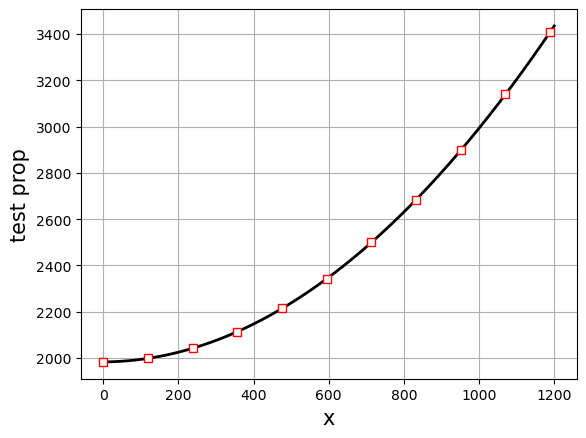

In [2]:
mat = LumpedMaterialProperty(name='test prop', function_coeffs=[1983, 0.01, 0.001])
mat.plot_prop(xMin=0, xMax=1200)

### Setting up a simple transient - no source, compared to actual solution

In [3]:
### Make a lumped capacitor
cp = LumpedMaterialProperty(name='specific heat', function_coeffs=[1983.0])
graphite = LumpedCapacitor(mass = 1, power = 0, h=1, A=1, C=cp, thermal_cond=1, initial_T=100,T_bulk=0, epsilon=1e-2)

the_times = np.linspace(0,5000, 1000)
the_dt = the_times[2] - the_times[1]
the_ts = np.array([])

for _ in the_times:
  graphite.solve(_dt = the_dt)
  graphite.update_old_to_most_recent()
  the_ts = np.append(the_ts, graphite.T)


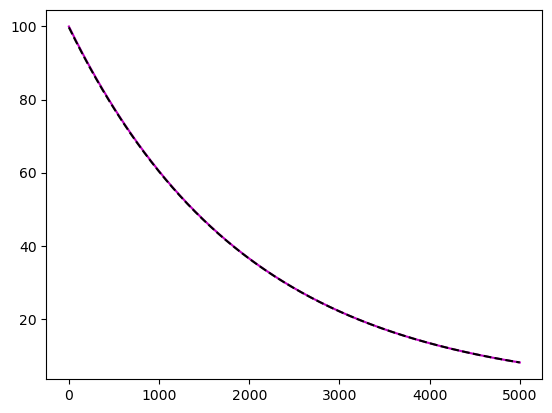

In [4]:
plt.plot(the_times, np.exp(-1.0/1983.0 * the_times)*100, 'm-')
plt.plot(the_times, the_ts, 'k--')


### Setup a simple case connecting to a real channel - each channel will have a thermal conductor attached to it.

In [5]:
# import openmc
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

import pandas as pd

from Data.msre_data import msre_data_dict

from Kernels.Helpers import *
from Kernels.NusseltModels import *

NOW RUNNING MSRE DATA USER INPUT
EXTENRAL TAU IS 7.017500000000002
Channel length L1 is 1.8148679046133467


LP AREA IS 0.27318354685967605
UP AREA IS 0.2803725875665097
DOWNCOMER AREA IS 0.09345752918883656
EXTERNAL LOOP AREA IS 0.5044909316020467


In [6]:
# FLUID
fluid = msre_data_dict['fluid']

### BC DATA ###
# mdot_csv = load_csv('Data/msre_flow_coastdown.csv')
mdot_bc = msre_data_dict['mdot_max']
T_bc = msre_data_dict['temp_bc']
pressure_bc = msre_data_dict['pressure_bc']

In [ ]:
"""SETTING UP THE CHANNEL"""
### Get channel from pkl file
ch = Channel.import_from_pkl(filename='Data/model_1_channels/all_channels_homogenized.pkl')

### Add htc field to channel since original implementation did not have htc added.
ch.htc = ScalarField(name='htc', mesh=ch.mesh, initial_value=-1.0)

### Set the heat source field.
ch.heat_source = np.ones(ch.nZones) * 8e6 / ch.ch_volume

### Set the nusselt model
the_nu_model = BasicNusseltModel()
ch.set_nu_model(nu_model = the_nu_model)

"""SETTING UP THE GRAPHITE CONDUCTOR"""

### Get heat transfer areas
full_ch_perimeter = msre_data_dict['full_ch_perimeter']
half_ch_perimeter = msre_data_dict['half_ch_perimeter']
num_full_ch = msre_data_dict['num_whole_channels']
num_half_ch = msre_data_dict['num_half_channels']

### Setup the lumped capacitor for a channel:
graphite_k = 80.0
graphite_cp = 1983.0
graphite_multiplier = 1e-5  # W/m3 in fuel -> W/m3 in graphite

# singh et al nonlinear dynamic model results.
salt_core_mass = 1374.0
graphite_core_mass = 3634.0
mass_ratio = graphite_core_mass / salt_core_mass

# Setup of graphtie NODAL values for each lumped mass
graphite_node_mass = ch.vol_vec[0] * ch.rho.T[0] * mass_ratio  # kg of graphite in each node
total_ht_area_whole_core = num_full_ch * full_ch_perimeter * ch.L1 + num_half_ch * half_ch_perimeter * ch.L1
graphite_node_ht_area =  total_ht_area_whole_core / ch.nZones
graphite_node_L = ch.L1 / ch.nZones
graphite_initial_T = 900.0  # K

# mass in kg of salt
mass_channel = np.sum(ch.vol_vec * ch.rho.T)

k_LMP = LumpedMaterialProperty(name='thermal conductivity', function_coeffs=[graphite_k])
cp_LMP = LumpedMaterialProperty(name='specific heat', function_coeffs=[graphite_cp])

# Make the graphite reference lumped capacitor --- power and htc willl be linked later
graphite = LumpedCapacitor(mass=graphite_node_mass,
                           power=-1,
                           h=-1,
                           A=graphite_node_ht_area,
                           C=cp_LMP,
                           thermal_cond=k_LMP,
                           initial_T=graphite_initial_T,
                           T_bulk=-1,
                           epsilon=1e-5)

"""
CONNECTING THE CONDUCTOR TO THE CHANNEL
"""

### Setup lumped capacitors using helper functions ->
### each channel node has associated deepcopy of lumped capacitor
ChannelConductionBuilder(channel=ch, conductor=graphite)

### Use functions that link some float values in the conductors to respective channels
LinkConductorPowersToChannel(channel=ch, multiplier=graphite_multiplier)
LinkConductorHTCToChannel(channel=ch, multiplier=1.0)
LinkConductorTbulkToChannel(channel=ch, multiplier=1.0)
ChannelArraySetTotalPower(ch=ch, cond_power=8e6*0.06, channel_power=8e6*0.94)



Old conductor power = 6065.984945607002
New conductor power = 480000.00000000006
Old channel power = 7999999.999999994
New channel power = 7519999.999999997
Total new power = 7999999.999999997
Conductor power fraction = 0.060000000000000026
Channel power fraction = 0.94


21.281750222713185
3.3501402891963608
0.2558354850488058
0.014612938353479876
0.0006684196996502578
2.5586692800061428e-05
8.450988389085978e-07
2.4628775463497732e-08
6.439222488552332e-10
1.5688783605583012e-11


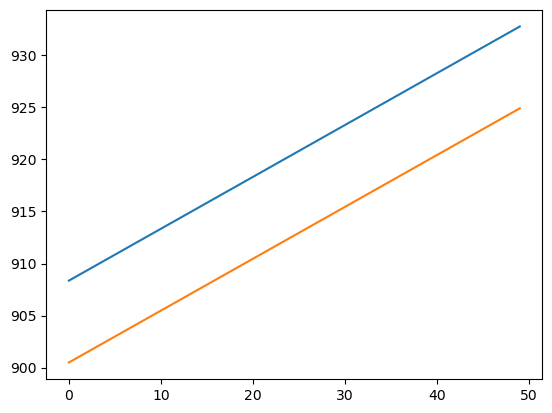

In [8]:
diff = 1e321
while diff > 1e-10:
  OLD = copy.deepcopy(ch.temp.T)
  ch.solve_channel_TH(_dt = 1e321)
  diff = max(abs(OLD - ch.temp.T))
  print(diff)

plt.plot(ch.get_cond_max())
plt.plot(ch.temp.T)